In [78]:
%matplotlib inline

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob
from scipy.stats import norm
import time

In [80]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume, rotate_volume, take_slice, project_volume_bis, backprojection, add_slice
from scipy.interpolate import RegularGridInterpolator, griddata

Make sure we have a local directory to read the data from, and that the data is there

In [81]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_data.npy


Pick a dataset by its keyword

In [82]:
keyword='particle'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

Let's have a look at the structure

In [83]:
ipv.quickscatter(structure[:,0], structure[:,1], structure[:,2], size=10*structure[:,3], marker='sphere')

Now let's check the volume

In [84]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.6/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


And now a few of the projection images

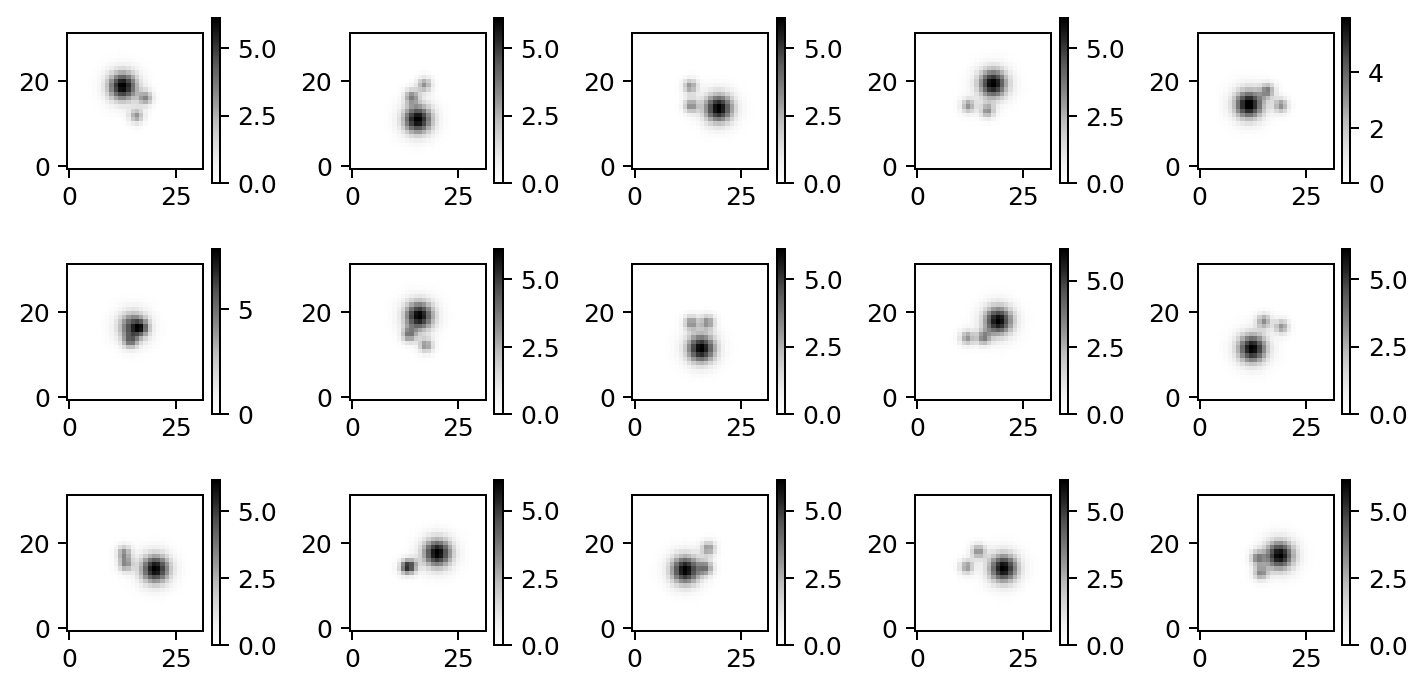

In [85]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4), dpi=180)
k=0
for i in np.arange(nrows):
    for j in np.arange(ncols):
        #axes[i,j].plot(metadataset[k,0:3])
        ax = axes[i,j]
        ims = ax.imshow(dataset[k], cmap='Greys', origin='lower')
        fig.colorbar(ims, ax=ax)
        k+=1
plt.tight_layout()
plt.show()

# Projections
We now look into projections where instead of rotating the particle, we rotate the slicing plane

time: 0.009912967681884766, sum of pixels: 300.3744184048809
time: 0.003036975860595703, sum of pixels: 50.570776788521215
sum of pixels for real projection: 300.2848719601263


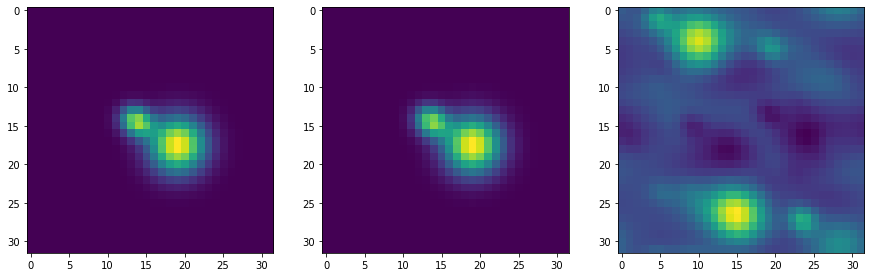

In [86]:
i=19
Rot = R.from_rotvec(-metadataset[i,0:3])
start1 = time.time()
projection = project_volume(volume, Rot)
end1 = time.time()
print(f"time: {end1-start1}, sum of pixels: {np.sum(projection)}")


start2 = time.time()
projection_bis = project_volume_bis(volume, Rot, angle_abs_mode=False)
end2 = time.time()
print(f"time: {end2-start2}, sum of pixels: {np.sum(projection_bis)}")

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(dataset[i])
ax[1].imshow(projection)
ax[2].imshow(projection_bis)

print(f"sum of pixels for real projection: {np.sum(dataset[i])}")
plt.show()

Here we plot from the left to the right:
- The projection as given in the dataset
- The projection obtained using our projection function (rotating the volume in real space and then projecting along the z-axis)
- The projection obtained using the slice-projection theorem

We also print the sum of all pixels, a good result must have the same value as the sum of all voxels of the volume (for low-res particule, this value is 300). 

In [87]:
#Note from Fred: j'en suis la. J'ai pas eu le temps de finir...

# Backprojection with known orientations


In [88]:
start = time.time()
#vol_part_reconstructed = backprojection(dataset[90:100], metadataset[90:100,0:3])
vol_reconstructed = backprojection(dataset[:100], metadataset[:100,0:3])
#vol_reconstructed = backprojection_bis(dataset[:100], metadataset[:100,0:3])
end = time.time()
print(f"time: {end-start}, sum of voxels: {np.sum(vol_reconstructed)}")
print(f"sum of pixels for real volume: {np.sum(volume)}")

ipv.quickvolshow((vol_reconstructed), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

time: 0.22251510620117188, sum of voxels: 233.7923974168942
sum of pixels for real volume: 300.28214945065133


In [89]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

This result is encouraging as we are able to reconstruct a volume similar to the desired one. However, the reconstruction lose "intensity" (the sum of the voxels is 250 while we should have 300), and we lose some precision around the littles atoms.
Path to explore:
- Appendix A. An iterative gridding reconstruction algorithm of the Relion paper
- The volume before taking the inverse fourier transform already has lost some intensity.

# Backprojection with unknown orientations

The backprojection works differently when the orientations aren't known. We need:
- a reference volume that we will project in a set of orientations (taken as uniformly as possible).
- a scoring function (named "proba" here) that will tell how close to images are, that we'll use to tell how probable an image comes from a specific projection. 

The algorithm works then by adding each image of the dataset in each direction of our set of orientations, weighed by this score.

In [101]:
def proba(projected_vol, image, scale=100):
    """
    This function calculates a probability score to tell how close two images are.
    """
    return np.prod((1-norm.cdf(np.abs(projected_vol-image), loc=0, scale=scale))*2)

def reconstruct(dataset, vols, quat_count, heterogeneity = False):
    """
    This function reconstructs the models at step t+1 given the models at step t
    To long, mainly because of the projection operator
    """
    x1s = np.linspace(0,1,quat_count)
    x2s = np.linspace(-1,1,quat_count)
    x3s = np.linspace(-1,1,quat_count)
    x4s = np.linspace(-1,1,quat_count)
    
    counts = np.zeros(vols.shape, dtype=complex)
    next_models = np.zeros(vols.shape, dtype=complex)

    #Sampling of SO3 (set of 3d rotations)
    for x1 in x1s:
        for x2 in x2s:
            for x3 in x3s: 
                for x4 in x4s:
                    quat = np.array((x1,x2,x3,x4))
                    if np.sum(np.abs(quat)) != 0:
                        rot = R.from_quat(quat)
                        
                        
                        for i in range(len(dataset)):
                            images_i = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dataset[i])))
                            
                            #Adding the i-th slice in the "rot"-rotated plane weighed by the similarity score 
                            if heterogeneity:      
                                for k in range(vols.shape[0]):
                                    projected_vol = project_volume(vols[k], rot)
                                    prob = proba(projected_vol, dataset[i])
                                    next_models[k], counts[k] = add_slice(next_models[k], counts[k], images_i, rot) 
                                    #we add the image, weighed by the probabity
                                    #to construct the models at the next iteration
                            else:
                                projected_vol = project_volume(vols, rot)
                                prob = proba(projected_vol, dataset[i])                                      
                                #probs+= prob
                                next_models, counts = add_slice(next_models, counts, images_i, rot, prob = prob)

    counts[counts == 0] = 1
    
    #Dividing by count to scale the solution/ taking the inverse fourier transform
    if (heterogeneity):
        for k in range(models.shape[0]):
            next_models[k] = next_models[k]/counts[k]
            next_models[k] = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(next_models[k]))))
                                                        
    else:
        next_models = next_models/counts
        next_models = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(next_models))))
        
    return next_models 

In [91]:
start = time.time()
vol_init = backprojection(dataset[:10], metadataset[:10,0:3]) #initial volume
vol2 = reconstruct(dataset, vol_init, quat_count = 4)
end = time.time()
print(f"time: {end-start}, sum of voxels before: {np.sum(vol_init)}, sum of voxels after: {np.sum(vol2)}")

0.0
0.333333333333
0.666666666667
1.0
time: 253.31505370140076, sum of voxels before: 230.9627070132026, sum of voxels after: 236.86582243281245


In [92]:
ipv.quickvolshow(vol_init.real, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [94]:
ipv.quickvolshow(vol2, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

# Full reconstruction with Expectation Maximization

In [ ]:
def EM(dataset, models_init, eps=1, n_steps=10, quat_count=4):
    """
    This function iterates the reconstruct function to converge to a local optimum
    """
    models = models_init
    step = 0
    end = False
    while step<n_steps and not(end):
        print('step:' +str(step+1))
        next_models = reconstruct(dataset, models, quat_count)
        step +=1
        if np.sum(np.abs(next_models - models)) < eps:
            end = True
            print("FINISHED EARLY")
        models = next_models
    
    return models

# Exploring 

In this part, we try several things to understand what doesn't work in the reconstruction:
- 1/ We first try to reconstruct a given projection of the volume, by summing the images of the dataset weighed by the similarity score. If that works, that means that the "proba" function works fine ==> it does work 
- 2/ We then try to backproject a dataset with known orientations, but orientations that are exclusively those obtained by the discretization of SO3 used previously. If that works, that means the discretization is sharp enough ==> it works but we still have a loss of intensity (makes sense, since we call the backprojection function). 
- 3/ We also try to launch the reconstruction algorithm starting from the solution to check whether our solution is at least stable or not ==> it isn't stable, we progressively lose information around the little atoms.

In [99]:
#### 1/ ####
def reconstruct_rot(dataset, vol, rot):
    """
    Here we try to reconstruct a projection of the volume, using the images of the dataset, weighed by the similarity 
    to the projection.
    """
    next_model = np.zeros(dataset[0].shape, dtype=complex)
    probs=0
    for i in range(len(dataset)):
        images_i = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dataset[i])))
        projected_vol = project_volume(vol, rot)
        prob = proba(projected_vol, dataset[i])                                      
        next_model += images_i * prob
        probs+=prob
 
    next_model = next_model/probs
    next_model = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(next_model))))
        
    return next_model 

time: 0.012311220169067383, sum of pixels: 300.2893747010606
time: 0.8097000122070312, sum of pixels: 300.2848306271711


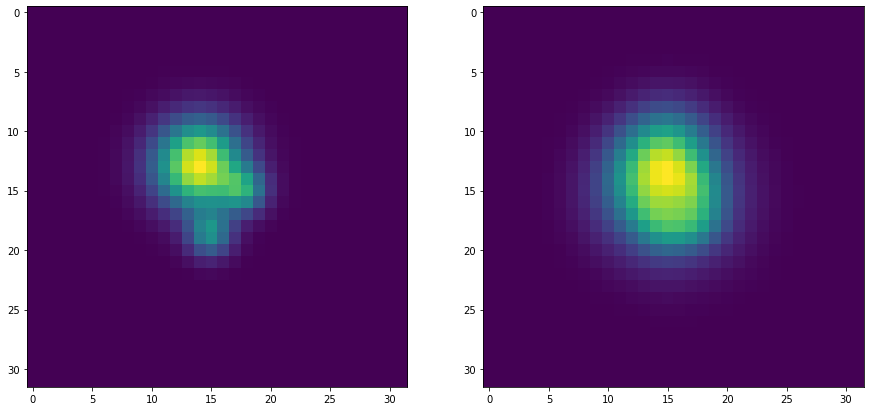

In [100]:
Rot_ = R.from_quat(np.array([-1.0,  0.66, -0.33 ,  0.33]))

start1 = time.time()
projection = project_volume(volume, Rot_)
end1 = time.time()
print(f"time: {end1-start1}, sum of pixels: {np.sum(projection)}")

start2 = time.time()
projection_ = reconstruct_rot(dataset, volume, Rot_)
end2 = time.time()
print(f"time: {end2-start2}, sum of pixels: {np.sum(projection_)}")

fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(projection)
ax[1].imshow(projection_)

That shows that the probability function works. We are able to reconstruct a given projection using the dataset, without any loss of intensity.

In [95]:
#### 2/ ####
def test(quat_count):
    """
    This function builds a custom dataset with the orientations given by the discretization of SO3 (using quats).
    It then backprojects (the orientations are known).
    """
    
    df = np.zeros((np.power(quat_count,4), dataset[0].shape[0], dataset[0].shape[1]))
    meta_df = np.zeros((np.power(quat_count,4), 3))
    print(df.shape)
    x1s = np.linspace(0,1,quat_count)
    x2s = np.linspace(-1,1,quat_count)
    x3s = np.linspace(-1,1,quat_count)
    x4s = np.linspace(-1,1,quat_count)
    i=0
    for x1 in x1s:
        for x2 in x2s:
            for x3 in x3s: 
                for x4 in x4s:
                    quat = np.array((x1,x2,x3,x4))
                    if np.sum(np.abs(quat))!=0:
                        r = R.from_quat(quat)
                        p = project_volume(volume, r)
                        df[i, :] = p
                        meta_df[i, :] = r.inv().as_rotvec()
                        i+=1
    
    return backprojection(df, meta_df[:,0:3])


In [96]:
v4 = test(4)
v6 = test(6)
v8 = test(8)

print(np.sum(v4))
print(np.sum(v6))
print(np.sum(v8))

(256, 32, 32)
(1296, 32, 32)
(4096, 32, 32)
237.341471107
236.093877531
236.053383777


In [97]:
ipv.quickvolshow(test(6), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

(1296, 32, 32)


In [412]:
#### 3/ ####
vol_init = backprojection(dataset[:2], metadataset[:2,0:3])
vol_em1 = EM(dataset,volume, eps=1, n_steps=1, quat_count = 4)
vol_em2 = EM(dataset,vol_em1, eps=1, n_steps=1, quat_count = 4)
vol_em3 = EM(dataset,vol_em2, eps=1, n_steps=1, quat_count = 4)


step:1
0.0
0.333333333333
0.666666666667
1.0
step:1
0.0
0.333333333333
0.666666666667
1.0
step:1
0.0
0.333333333333
0.666666666667
1.0


In [413]:
ipv.quickvolshow(vol_em1, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [414]:
ipv.quickvolshow(vol_em2, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [415]:
ipv.quickvolshow(vol_em3, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)